In [7]:
import numpy as np
import rescomp as rc
import networkx as nx
from scipy import sparse
import matplotlib.pyplot as plt
import sklearn.gaussian_process as GP
from scipy.interpolate import CubicSpline

import warnings
warnings.filterwarnings('ignore')

In [8]:
def plot2d(t, U, color=None, title=''):
    if color is None:
        color = np.random.rand(U.shape[1], 3)
    for i, c in enumerate(color):
        plt.plot(t, U[:, i], c=c)
    plt.title(title)
    plt.show()
    return color

In [9]:
def valid_prediction_index(err, tol):
    """First index i where err[i] > tol. err is assumed to be 1D and tol is a float. If err is never greater than tol, then len(err) is returned."""
    mask = np.logical_or(err > tol, ~np.isfinite(err))
    if np.any(mask):
        return np.argmax(mask)
    return len(err)

def wa_vptime(ts, Uts, pre, vpttol=0.5):
    """
    Valid prediction time for a specific instance.
    """
    err = np.linalg.norm(Uts-pre, axis=1, ord=2)
    idx = valid_prediction_index(err, vpttol)
    if idx == 0:
        vptime = 0.
    else:
        vptime = ts[idx-1] - ts[0]

    return vptime

In [10]:
# GET TRAINING AND TESTING SIGNALS
t, U = rc.orbit('lorenz', duration=1000)
u = CubicSpline(t, U)
tr = t[:4000]
Utr = u(t[:4000])
ts = t[4000:]
Uts = u(t[4000:])

tr = t[900:1100]
Utr = u(t[900:1100])

In [11]:
def runit(rho, pthin, a, g, s, norm=True):

    seed=52673
    np.random.seed(seed)

    # OTHER PARAMS
    n = 50
    c = 1

    # CREATE GRAPH
    A = nx.erdos_renyi_graph(n,c*(1-pthin)/(n-1),directed=True)
    A = sparse.dok_matrix(nx.adj_matrix(A).T)

    # MAKE RESERVOIR
    B = A*(rho/np.abs(sparse.linalg.eigs(A.astype(float),k=1)[0][0]))
    res = rc.ResComp(B.tocoo(), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
    res.train(tr, Utr)

    # RES_CONDITION
    r0 = res.initial_condition(Utr[0])
    res_states = res.internal_state_response(tr, Utr, r0)
    print(r0)

    # GET VPT
    Upred, _ = res.predict(ts, r0=r0, return_states=True)

    # VPT
    vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)

    return Upred, vpt, res_states

In [12]:
seed=52673
np.random.seed(seed)  


# Generate attractor orbit
t, U = rc.orbit('lorenz', trim=True, duration=30)
tr_t = t[900:1100]
tr_U = U[900:1100]

# Train res
res_sz = 50
rescomp = rc.ResComp(res_sz=res_sz, mean_degree=0.1, map_initial='activ_f', ridge_alpha=0.0001, gamma=5, sigma=0.05)
rescomp.train(tr_t, tr_U)

# Set t, U
r0 = rescomp.initial_condition(tr_U[0])   ######### <-----------------------------  we grab r0 after we train
res_signal = rescomp.internal_state_response(tr_t, tr_U, r0)   ######## <---------  we pass r0 back in to get the state response ... but shouldn't 
###                                                                             that be included in the state response???? or is it different?)
print(r0)

# Reconstructed signal
U_hat = res_signal @ rescomp.W_out.T

# Predicted signal
pred_t = np.linspace(51,55.99,500)
pred_res, pred_states = rescomp.predict(np.linspace(tr_t[-1], tr_t[-1]+5, 500), r0=rescomp.r0, return_states=True)   ### and then when we predict, we pass in r0 again???

# QUESTION - what is the difference between r0 = rescomp.init_condit(asdf) which is grabbed from that function verses
# and rescomp.r0  which is saved in the object?

[-0.41877141  0.35339724  0.31560464 -0.4154923  -0.46590747 -0.20782921
  0.74888225 -0.72968012  0.81752831  0.85429809  0.43985669  0.13380411
  0.12145509  0.06725671 -0.92360442  0.80548516  0.0403308   0.65271323
 -0.52025424 -0.01233589  0.71630155 -0.12024135  0.52307088 -0.66782954
 -0.48872849  0.53512135  0.10024018 -0.72506597  0.76455499 -0.73758766
 -0.04336103  0.39022201  0.06536301  0.50346672 -0.252371    0.15250952
 -0.46236812 -0.01550771  0.16396663 -0.00245245 -0.40073649  0.51300782
  0.44654879 -0.28434316  0.84262172  0.33149977  0.04608153 -0.0033509
  0.72932889  0.64962325]


# Diversity Figures
### compare examples

In [13]:
my_pred_50_0, my_vpt_50_0, res_states_50_0 = runit(50, 0, 0.0001, 5, 0.05, norm=True)

[-3.57126609e+02 -3.49840291e+02 -2.31620676e+02  1.66820941e+01
  2.21222309e+01 -2.34966409e+02 -3.55664387e+02  5.15756853e+01
  3.37568897e+01 -2.01565170e+01 -3.47299677e+02  4.15887017e+01
 -3.25665140e+01  1.16945617e-02 -2.44332714e+02 -3.53327308e+02
 -3.45010986e+02 -2.47228203e+02  1.64306110e-01 -3.43667065e+02
 -2.50007220e+02  2.26855599e-01  4.06056455e+01 -2.52666135e+02
 -3.50591939e+02  9.46776589e+01  1.01024385e+02 -3.49548522e+02
 -3.38722714e+02 -2.57605008e+02 -3.48423453e+02 -3.36731634e+02
 -2.59871865e+02 -3.47206739e+02 -3.34546620e+02 -2.61992286e+02
 -3.45887878e+02 -3.32152285e+02 -2.68275540e+01  9.55013567e+00
  4.16486789e+01 -2.65746875e+02 -3.42899183e+02 -3.26668777e+02
 -2.67351032e+02  2.85205618e+01 -3.23543748e+02 -1.28981319e+00
 -3.39362476e+02  9.67986184e+03]


In [14]:
my_pred_50_80, my_vpt_50_80, res_states_50_80 = runit(50, 0.80, 0.0001, 5, 0.05, norm=True)

[ 1.          0.70803697 -0.98568832 -0.95439265  0.82829309  0.85000663
 -0.6903619   0.89417991  0.98540171  0.70794971 -0.99789341  0.98552287
  0.87718453  1.         -1.          0.97593764 -1.          0.96701072
  0.99565314  0.75130627  0.24361891  0.95913418  0.94454574  0.40317499
  0.92988841 -0.98674365 -0.96099093  0.46938995  0.13703591  0.52307411
 -1.          0.97883847 -0.87325117  0.53183409 -1.          1.
 -0.04672377 -0.1236518  -0.92433496 -0.82635055  0.93416705  1.
  0.96306603  0.96950206 -0.95432341 -0.80258443  0.80050569 -0.82928347
 -0.47034601  0.34576393]


Text(0.5, 0.98, '')

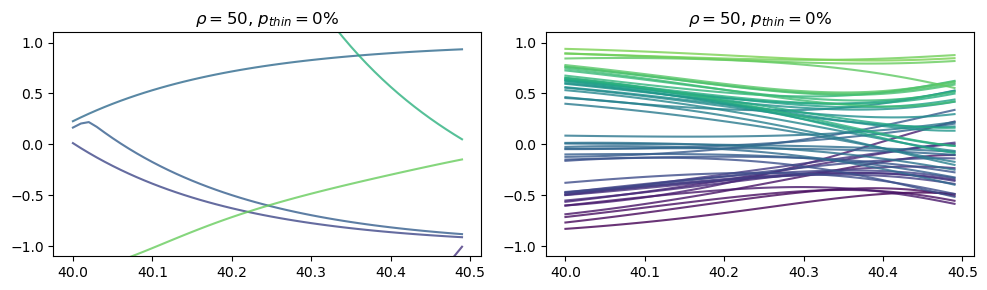

In [19]:
plt.rcParams["figure.figsize"] = (10,3)

fig, (ax1, ax2) = plt.subplots(1,2)

for i,c in enumerate(plt.get_cmap('viridis')(np.linspace(0,0.8,50))):
    ax1.plot(t[:50], res_states_50_0[:50, [i]], '-', color=c, alpha=0.8)
ax1.set_ylim(-1.1,1.1)
ax1.set_title(r'$\rho=50$, $p_{thin}=0\%$')


order2 = np.argsort(pred_states[0])
for i,c in enumerate(plt.get_cmap('viridis')(np.linspace(0,0.8,50))):
    ax2.plot(t[:50], pred_states[:50, order2[i]], '-', color=c, alpha=0.8)
ax2.set_ylim(-1.1,1.1)
ax2.set_title(r'$\rho=50$, $p_{thin}=0\%$')

plt.tight_layout()
fig.suptitle('')

### deriv metric counter-ex

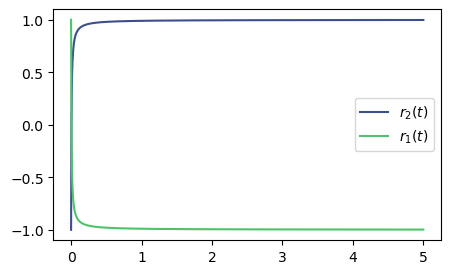

In [101]:
plt.rcParams["figure.figsize"] = (5,3)

dom = np.linspace(0,5,1000)
f = np.vectorize(lambda x : 1/(100*(x+0.005))-1)

plt.plot(dom, -f(dom), c=plt.get_cmap('viridis')(np.linspace(0,0.8,500))[150], label=r'$r_2(t)$')
plt.plot(dom, f(dom), c=plt.get_cmap('viridis')(np.linspace(0,0.8,500))[450], label=r'$r_1(t)$')

plt.legend()

### abs value metric counter-ex

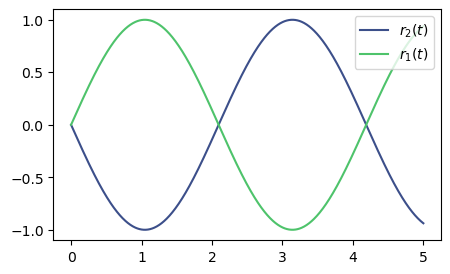

In [111]:
plt.rcParams["figure.figsize"] = (5,3)

dom = np.linspace(0,5,1000)
f = np.vectorize(lambda x : np.sin(1.5*x))

plt.plot(dom, -f(dom), c=plt.get_cmap('viridis')(np.linspace(0,0.8,500))[150], label=r'$r_2(t)$')
plt.plot(dom, f(dom), c=plt.get_cmap('viridis')(np.linspace(0,0.8,500))[450], label=r'$r_1(t)$')

plt.legend(loc="upper right")